# Imports

In [549]:
import pandas as pd

In [550]:
import matplotlib.pyplot as plt

In [551]:
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

# Functions

In [552]:
def inspect_df(df : pd.DataFrame):
    """
    Display basic structural information about a DataFrame.

    This function prints the number of rows and columns, checks for
    missing values, and displays the data types of each feature.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be inspected.

    Returns
    -------
    None
        This function does not return any value. It prints
        summary information to the console.

    Notes
    -----
    - If no missing values are present, the function explicitly
      prints that there are zero null values.
    - If missing values exist, the function prints the number
      of null values for each column.
    - Feature data types are displayed using `df.dtypes`.
    """
    print(f'Rows:       {df.shape[0]}')
    print(f'Columns:    {df.shape[1]}')
    print("-" * 30)

    null_values = df.isna().sum()
    if (null_values.sum() == 0):
        print('Null values: 0')
    else:
        print('Null values:')
        print(null_values)
    
    print("-" * 30)
    print('Feature data types:')
    print(df.dtypes)
    print("")

In [553]:
def evaluate_regressor(model, x_test : pd.DataFrame, y_test : pd.Series, title : str):
    """
    Evaluate the performance of a regression model on a test dataset.

    This function generates predictions using the provided model and
    computes common regression metrics: MAE, MSE, MSLE (if applicable),
    and R² score. The results are printed to the console.

    Parameters
    ----------
    model : estimator
        A trained regression model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True target values corresponding to `x_test`.

    Returns
    -------
    y_pred : array-like
        Predicted values generated by the model on `x_test`.

    Notes
    -----
    - MAE (Mean Absolute Error) measures the average absolute difference
      between true and predicted values.
    - MSE (Mean Squared Error) penalizes larger errors more heavily.
    - MSLE (Mean Squared Logarithmic Error) is computed only if all true
      and predicted values are greater than -1. Otherwise, it is not
      applicable.
    - R² score is bounded in the interval (-∞, 1]. Values below 0
      indicate that the model performs worse than a baseline model
      predicting the mean target value.
    """
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    if (y_test > -1).all() & (y_pred > -1).all():
        msle = mean_squared_log_error(y_test, y_pred)
    else:
        msle = "N/A (y_test contiene valori <= -1)"
    r2 = r2_score(y_test, y_pred)

    print(f"{title.title()}:")
    print(f"MAE:    {mae}")
    print(f"MSE:    {mse}")
    print(f"MSLE:   {msle}")
    print(f"R2:     {r2}")
    print("")

    return y_pred

In [554]:
def kfold_crossvalidation(
        model, 
        x_train : pd.DataFrame, 
        y_train : pd.Series, 
        cv : int, 
        title : str
    ):
    """
    Perform K-Fold cross-validation on a given model.

    This function evaluates a model using cross-validation,
    prints the mean and standard deviation of the obtained
    scores, and returns the full array of cross-validation results.

    Parameters
    ----------
    model : estimator
        A machine learning model implementing the scikit-learn API.
    x_train : array-like
        Feature matrix of the training dataset.
    y_train : array-like
        Target values corresponding to `x_train`.
    cv : int
        Number of folds for K-Fold cross-validation.
        (Note: the current implementation uses `cv=10` internally.)
    title : str
        Descriptive title to display in the printed output.

    Returns
    -------
    outputs : numpy.ndarray
        Array containing the cross-validation scores for each fold.

    Notes
    -----
    - Cross-validation is performed using `cross_val_score`
      with parallel processing enabled (`n_jobs=-1`).
    - The function prints the mean and standard deviation
      of the cross-validation scores.
    """
    outputs = cross_val_score(model, x_train, y_train, cv=cv, n_jobs=-1)

    print(f'{title.title()}:')
    print(f'Mean:               {outputs.mean()}')
    print(f'Std:                {outputs.std()}')
    print(f'Every fold scores:  {outputs}')
    print('-' * 30)
    return outputs

In [555]:
def get_categorical_features(df : pd.DataFrame):
    return df.select_dtypes(include=['object']).columns

In [556]:
def get_k_correlated(df : pd.DataFrame, y_name : str, k : int, abs : bool, ascending : bool):
    """
    Retrieve the names of the top-k features most correlated with a target variable.

    This function computes the correlation matrix of the DataFrame and
    returns the names of the k features with the highest (or lowest)
    correlation with the specified target column.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing numerical features.
    y_name : str
        Name of the target column for which correlations are computed.
    k : int
        Number of correlated features to retrieve.
    abs : bool
        If True, correlations are sorted by their absolute values.
        If False, raw correlation values are used.
    ascending : bool
        Sorting order of correlations.
        If True, correlations are sorted in ascending order.
        If False, correlations are sorted in descending order.

    Returns
    -------
    pandas.Index
        Index containing the names of the top-k correlated features,
        excluding the target variable itself.

    Notes
    -----
    - The function assumes that `y_name` exists in `df` and that the
      DataFrame contains only numerical columns for correlation computation.
    - The first element (self-correlation of the target) is excluded
      from the result.
    """
    if (abs):
        y_corr = df.corr()[y_name].abs().sort_values(ascending=ascending)
    else:
        y_corr = df.corr()[y_name].sort_values(ascending=ascending)
    return y_corr[1:(k+1)].index

# Esame

## Analisi

In [557]:
backup = pd.read_csv('./dataset.csv', sep=',')
df = backup.copy()
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


### Domanda 1:

In [558]:
inspect_df(df)

Rows:       7500
Columns:    11
------------------------------
Null values:
winery            0
wine              0
year              2
rating            0
num_reviews       0
country           0
region            0
price             0
type            545
body           1169
acidity        1169
dtype: int64
------------------------------
Feature data types:
winery             str
wine               str
year               str
rating         float64
num_reviews      int64
country            str
region             str
price          float64
type               str
body           float64
acidity        float64
dtype: object



Numero istanze: 7500 \
Il dataset contiene valori nulli.

<Axes: >

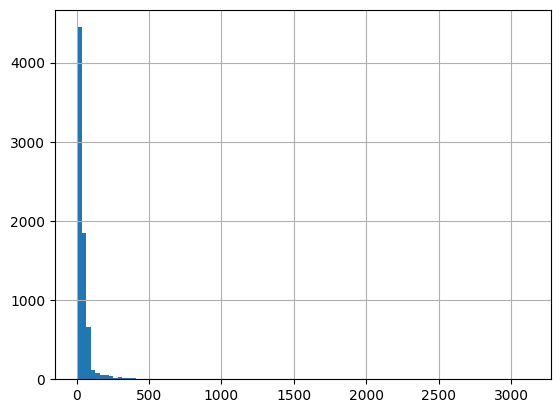

In [559]:
df['price'].hist(bins=100)

La maggior parte dei prezzi è sotto circa i 70€

### Domanda 2:

In [560]:
df.groupby('region')['price'].mean().nlargest(3)

region
Montilla-Moriles      178.689615
Conca de Barbera      164.543333
Jerez Palo Cortado    144.475455
Name: price, dtype: float64

Le tre regioni con il prezzo medio più elevato in ordine decrescente sono:
- Montilla-Moriles
- Conca de Barbera
- Jerez Palo Cortado

### Domanda 3:

In [561]:
most_reviewed = df[df['num_reviews'] >= 100]
most_reviewed['price'] = pd.cut(most_reviewed['price'], 3, labels=['low', 'medium', 'high'])
most_reviewed['RiojaOrRibera'] = ((most_reviewed['region'] == 'Rioja') | (most_reviewed['region'] == 'Ribera del Duero')).astype(int)
most_reviewed.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity,RiojaOrRibera
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,low,Ribera Del Duero Red,5.0,3.0,1
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,low,Ribera Del Duero Red,5.0,3.0,1
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,low,Ribera Del Duero Red,5.0,3.0,1
5,Vega Sicilia,Unico,1998,4.8,1209,Espana,Ribera del Duero,low,Ribera Del Duero Red,5.0,3.0,1
6,Vega Sicilia,Unico,2010,4.8,1201,Espana,Ribera del Duero,low,Ribera Del Duero Red,5.0,3.0,1


In [586]:
pivot = most_reviewed.pivot_table(index=['price'], columns=['RiojaOrRibera'], values=['rating'], aggfunc='mean')
pivot

rating          
RiojaOrRibera         0         1
price                            
low            4.225303  4.237768
medium         4.642857  4.663158
high           4.700000  4.650000

Il rating medio per i vini provenienti da Rioja o Ribera del Duero è leggermente superiore a quello delle altre regioni per le fasce di prezzo bassa e media, mentre per la fascia alta è leggermente inferiore.

### Domanda 4:

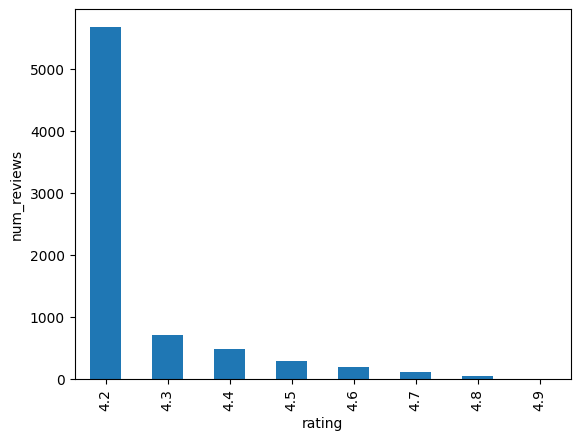

In [ ]:
df.groupby('rating')['num_reviews'].count().plot.bar()
plt.ylabel('num_reviews')
plt.show()

I vini più popolari sono quelli con rating più basso, cioè aventi qualità percepita inferiore.

## Trasformazione e Predizione

### Domanda 1:

In [565]:
df = backup.copy()
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


A mio parere non ci sono attributi da considerarsi "inutili".

In [566]:
df = df.drop_duplicates()
df = df.dropna()
inspect_df(df)

Rows:       1775
Columns:    11
------------------------------
Null values: 0
------------------------------
Feature data types:
winery             str
wine               str
year               str
rating         float64
num_reviews      int64
country            str
region             str
price          float64
type               str
body           float64
acidity        float64
dtype: object



In [567]:
cat_features = get_categorical_features(df)
df[cat_features] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit_transform(df[cat_features])
df.head()

/tmp/ipykernel_9018/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns


,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,371.0,667.0,61.0,4.9,58,0.0,61.0,995.00,19.0,5.0,3.0
1,30.0,714.0,66.0,4.9,31,0.0,64.0,313.50,18.0,4.0,2.0
2,395.0,683.0,57.0,4.8,1793,0.0,49.0,324.95,11.0,5.0,3.0
3,395.0,683.0,47.0,4.8,1705,0.0,49.0,692.96,11.0,5.0,3.0
4,395.0,683.0,44.0,4.8,1309,0.0,49.0,778.06,11.0,5.0,3.0


In [568]:
X, y = df.drop(columns='price'), df['price']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [569]:
lr = LinearRegression()
lr.fit(x_train, y_train)
_ = evaluate_regressor(lr, x_train, y_train, 'linear regression - train data')
_ = evaluate_regressor(lr, x_test, y_test, 'linear regression - test data')

Linear Regression - Train Data:
MAE:    130.2166054513148
MSE:    61097.623814036735
MSLE:   N/A (y_test contiene valori <= -1)
R2:     0.31779150419640934

Linear Regression - Test Data:
MAE:    113.05159260247879
MSE:    35305.015275601756
MSLE:   N/A (y_test contiene valori <= -1)
R2:     0.4661383644643988



In [570]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
_ = evaluate_regressor(rf, x_train, y_train, 'random forest regression - train data')
_ = evaluate_regressor(rf, x_test, y_test, 'random forest regression - test data')

Random Forest Regression - Train Data:
MAE:    29.60534148942254
MSE:    5928.701946652311
MSLE:   0.10495955261307398
R2:     0.9338008487956242

Random Forest Regression - Test Data:
MAE:    55.634862129664654
MSE:    14626.035893522412
MSLE:   0.3264840209197856
R2:     0.7788337044308163



In [571]:
dr = DummyRegressor()
dr.fit(x_train, y_train)
_ = evaluate_regressor(dr, x_train, y_train, 'dummy regression - train data')
_ = evaluate_regressor(dr, x_test, y_test, 'dummy regression - test data')

Dummy Regression - Train Data:
MAE:    151.67907032649808
MSE:    89558.57951031275
MSLE:   1.688462784316441
R2:     0.0

Dummy Regression - Test Data:
MAE:    146.28799559130854
MSE:    66172.85903804477
MSLE:   1.6197751920666483
R2:     -0.0006269783016044084



Dai risultati si osserva che, come mostrato dal R2 score, il random forest regressor è senza dubbio il miglior modello out-of-the-box rispetto agli altri analizzati. \
Si nota anche che abbia sviluppato un'ottima comprensione dei dati di training (probabile sintomo di overfitting), cosa che non si può dire del linear regressor in quanto il suo errore sui dati di training è quasi uguale a quello in test. \
Il dummy regressor è il peggior modello con score decisamente distanti da quelli calcolati dagli altri due modelli. \
Il linear regressor si pone in una posizione intermedia tra random forest e dummy.

### Domanda 2:

In [572]:
kfold_crossvalidation(RandomForestRegressor(), x_train, y_train, 5, 'random forest')
kfold_crossvalidation(LinearRegression(), x_train, y_train, 5, 'linear')

Random Forest:
Mean:               0.5678638106272332
Std:                0.07312323234781877
Every fold scores:  [0.63111694 0.45914533 0.65099916 0.58960817 0.50844946]
------------------------------
Linear:
Mean:               0.3067532242739494
Std:                0.035734011470977656
Every fold scores:  [0.32421776 0.29116051 0.26516594 0.36734358 0.28587833]
------------------------------


array([0.32421776, 0.29116051, 0.26516594, 0.36734358, 0.28587833])

Rispetto ai valori di R2 medi ottenuti nel punto precedente osserviamo che essi sono molto simili per il linear regressor, ma peggiori per il random forest regressor.

Dagli output si nota che tra i due modelli quello che ha più alta variabilità nei risultati è il random forest regressor. \
Ad ogni modo, nessuno dei due modelli ha una variabilità eccessivamente alta in senso assoluto.

### Domanda 3:

In [573]:
parameters = {
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth' : [5, 10, 15, 20, 30, 40, 50]
}

gscv = GridSearchCV(RandomForestRegressor(), parameters, cv=10, n_jobs=-1)
gscv.fit(x_train, y_train)
_ = evaluate_regressor(gscv, x_train, y_train, 'random forest - grid search (train data)')
_ = evaluate_regressor(gscv, x_test, y_test, 'random forest - grid search (test data)')

Random Forest - Grid Search (Train Data):
MAE:    28.434879210029703
MSE:    5349.333735266633
MSLE:   0.10313601728714206
R2:     0.9402700024440355

Random Forest - Grid Search (Test Data):
MAE:    54.3772331591046
MSE:    13481.72636855397
MSLE:   0.3179769774597189
R2:     0.7961372787187673



Gli score indicano performance leggermente superiori rispetto a quelli ottenuti al punto 1.

### Domanda 4:

In [574]:
most_corr = df[get_k_correlated(df, 'price', 4, False, False)]
most_corr = pd.concat([most_corr, df['price']], axis=1)
most_corr.head()

,rating,body,wine,region,price
0,4.9,5.0,667.0,61.0,995.00
1,4.9,4.0,714.0,64.0,313.50
2,4.8,5.0,683.0,49.0,324.95
3,4.8,5.0,683.0,49.0,692.96
4,4.8,5.0,683.0,49.0,778.06


In [575]:
X, y = most_corr.drop(columns='price'), most_corr['price']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [576]:
lr = LinearRegression()
lr.fit(x_train, y_train)
_ = evaluate_regressor(lr, x_train, y_train, 'linear regression most corr - train data')
_ = evaluate_regressor(lr, x_test, y_test, 'linear regression most corr - test data')

Linear Regression Most Corr - Train Data:
MAE:    137.1854272537108
MSE:    66447.40273254742
MSLE:   N/A (y_test contiene valori <= -1)
R2:     0.2622848642432086

Linear Regression Most Corr - Test Data:
MAE:    124.24184941892844
MSE:    45709.66169574774
MSLE:   N/A (y_test contiene valori <= -1)
R2:     0.29134529284994937



In [577]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
_ = evaluate_regressor(rf, x_train, y_train, 'random forest regression most corr - train data')
_ = evaluate_regressor(rf, x_test, y_test, 'random forest regression most corr - test data')

Random Forest Regression Most Corr - Train Data:
MAE:    42.473294094647585
MSE:    15347.800331883767
MSLE:   0.14772806245243178
R2:     0.829605008776997

Random Forest Regression Most Corr - Test Data:
MAE:    68.86183990189873
MSE:    24986.61345318757
MSLE:   0.4885633855744928
R2:     0.6126227895275064



In [578]:
dr = DummyRegressor()
dr.fit(x_train, y_train)
_ = evaluate_regressor(dr, x_train, y_train, 'dummy regression most corr - train data')
_ = evaluate_regressor(dr, x_test, y_test, 'dummy regression most corr - test data')

Dummy Regression Most Corr - Train Data:
MAE:    154.9530465568693
MSE:    90071.89836817131
MSLE:   1.7209047516300404
R2:     0.0

Dummy Regression Most Corr - Test Data:
MAE:    140.15322582986204
MSE:    64664.27239670025
MSLE:   1.5848706333913702
R2:     -0.0025154271185008348



Le performance sono peggiorate per linear regressor e random forest regressor. \
Il dummy regressor è stabile.

### Domanda 5:

In [579]:
df = backup.copy()
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [580]:
df = df.drop_duplicates()
inspect_df(df)

Rows:       2048
Columns:    11
------------------------------
Null values:
winery           0
wine             0
year             2
rating           0
num_reviews      0
country          0
region           0
price            0
type           106
body           271
acidity        271
dtype: int64
------------------------------
Feature data types:
winery             str
wine               str
year               str
rating         float64
num_reviews      int64
country            str
region             str
price          float64
type               str
body           float64
acidity        float64
dtype: object



In [581]:
cat_features = get_categorical_features(df)
df[cat_features] = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit_transform(df[cat_features])
df.head()

/tmp/ipykernel_9018/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns


,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,422.0,759.0,61.0,4.9,58,0.0,69.0,995.00,19.0,5.0,3.0
1,33.0,819.0,66.0,4.9,31,0.0,74.0,313.50,18.0,4.0,2.0
2,447.0,778.0,57.0,4.8,1793,0.0,57.0,324.95,11.0,5.0,3.0
3,447.0,778.0,47.0,4.8,1705,0.0,57.0,692.96,11.0,5.0,3.0
4,447.0,778.0,44.0,4.8,1309,0.0,57.0,778.06,11.0,5.0,3.0


In [582]:
X, y = df.drop(columns='price'), df['price']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [583]:
preprocessor = ColumnTransformer(transformers=[
    ('scaling', StandardScaler(), ['rating', 'num_reviews']),
], remainder='passthrough', n_jobs=-1)

pipeline = Pipeline(steps=[
    ('remove_na', SimpleImputer(strategy='mean').set_output(transform='pandas')),
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor())
])

pipeline.fit(x_train, y_train)
_ = evaluate_regressor(pipeline, x_train, y_train, 'pipeline 1 - train data')
_ = evaluate_regressor(pipeline, x_test, y_test, 'pipeline 1 - test data')

Pipeline 1 - Train Data:
MAE:    24.094960916527953
MSE:    3998.2163747232626
MSLE:   0.08975587123470274
R2:     0.9408211880834118

Pipeline 1 - Test Data:
MAE:    74.27575213254075
MSE:    40463.722217200266
MSLE:   0.41428061400745564
R2:     0.5657657863738852



Rispetto ai risultati ottenuti nel punto 3, le performance del random forest regressor usato in questa pipeline sono peggiorate in testing.

### Domanda 6:

In [584]:
parameters = {
    'dim_red__k' : [2, 3, 4, 5, 6],
    'model__criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'model__max_depth' : [5, 10, 15, 20, 30, 40]
}

preprocessor = ColumnTransformer(transformers=[
    ('scaling', StandardScaler(), ['rating', 'num_reviews']),
], remainder='passthrough', n_jobs=-1)

pipeline = Pipeline(steps=[
    ('remove_na', SimpleImputer(strategy='most_frequent').set_output(transform='pandas')),
    ('preprocessing', preprocessor),
    ('dim_red', SelectKBest()),
    ('model', RandomForestRegressor())
])

gscv = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1)
gscv.fit(x_train, y_train)
_ = evaluate_regressor(gscv, x_test, y_test, 'pipeline 2')

/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserW

Pipeline 2:
MAE:    77.55658617217196
MSE:    41630.00974901829
MSLE:   0.4340142248436534
R2:     0.5532498357521783



I risultati ottenuti con questa pipeline sono leggermente peggiori rispetto a quelli prodotti dalla precedente.